# 3D MRI Segmentation

In [1]:
# Libaries
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from keras.utils import to_categorical
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


2025-01-08 16:19:46.182043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Analysis and Visualization

In [2]:
# Load and preprocess data
data_U = loadmat('data/Brain.mat')
T1_U = data_U['T1']         # MRI slices
label_U = data_U['label']   # Corresponding labels

print("MRI Data Shape:", T1_U.shape)
print("Label Shape:", label_U.shape)

MRI Data Shape: (362, 434, 10)
Label Shape: (362, 434, 10)


In [3]:
print(data_U.keys())
print(T1_U[1:101, 1:101, 1])
print(label_U[1:101, 1:101, 1])

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])
[[  6787.634    6907.175    6907.175  ...  12645.159   13840.573
   13960.114 ]
 [  6429.01     6668.0923   7026.7163 ...  12525.618   13481.949
   14079.655 ]
 [  6548.551    6429.01     6668.0923 ...  15753.234   17426.812
   18861.309 ]
 ...
 [ 10852.039    9776.167    9058.919  ... 288546.6    285318.97
  279939.6   ]
 [ 10493.415    9895.709    9537.085  ... 291176.5    289263.8
  285318.97  ]
 [ 10015.25    10134.791    9895.709  ... 292371.9    291056.94
  288187.97  ]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]]


In [4]:
# Visualize an example slice and ground truth
def visualize_example(data, label, slice_idx):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("MRI Slice")
    plt.imshow(data[:, :, slice_idx], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(label[:, :, slice_idx], cmap='jet')
    plt.axis('off')
    plt.show()

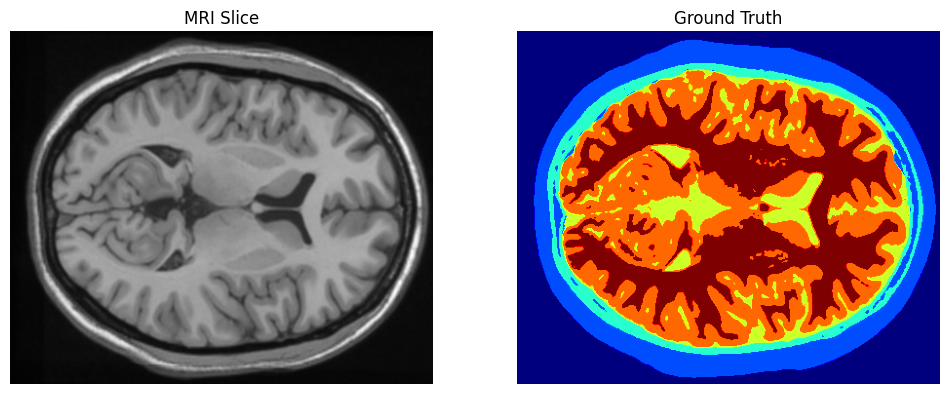

In [5]:
# Visualize slice 5 as an example
visualize_example(T1_U, label_U, slice_idx=5)

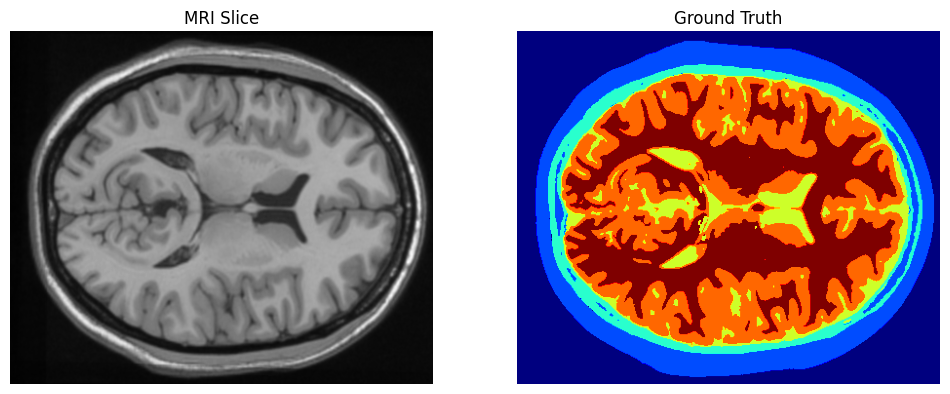

In [6]:
visualize_example(T1_U, label_U, slice_idx=9)

## Data Preprocessing

In [7]:
# Constants (TODO: add them to config)
VOLUME_ROWS = 362
VOLUME_COLS = 434
VOLUME_DEPS = 10
PATCH_SIZE = 16
EXTRACTION_STEP = 10
NUM_CLASSES = 6
BATCH_SIZE = 2
NUM_EPOCHS  = 20

In [8]:
# Function to extract patches
def extract_patches(volume, patch_size, step):
    """
    Extract 3D patches from a 3D volume.
    Args:
        volume: The input 3D numpy array (H x W x D).
        patch_size: Tuple indicating the size of patches (p, p, p).
        step: Step size for sliding window.

    Returns:
        patches: A numpy array of shape (num_patches, patch_size, patch_size, patch_size).
    """
    patches = []
    for i in range(0, VOLUME_ROWS - patch_size + 1, step):
        for j in range(0, VOLUME_COLS - patch_size + 1, step):
            for k in range(0, VOLUME_DEPS - patch_size + 1, step):
                patch = volume[i:i + patch_size, j:j + patch_size, k:k + patch_size]
                patches.append(patch)
    return np.array(patches)

def extract_patches_with_padding(volume, patch_size, step):
    """
    Extract 3D patches from a volume with padding for smaller dimensions.
    Args:
        volume: Input 3D numpy array (H x W x D).
        patch_size: Size of patches to extract (p, p, p).
        step: Step size for sliding window.

    Returns:
        patches: A numpy array of extracted patches.
    """
    h, w, d = volume.shape
    print('volume BEFORE padding: ', volume.shape)

    # Add padding if necessary
    pad_h = max(0, patch_size - h)
    pad_w = max(0, patch_size - w)
    pad_d = max(0, patch_size - d)

    # Pad the volume along each axis
    padded_volume = np.pad(
        volume,
        ((0, pad_h), (0, pad_w), (0, pad_d)),
        mode='constant',
        constant_values=0
    )

    print('volume AFTER padding: ', padded_volume.shape)

    patches = []
    padded_h, padded_w, padded_d = padded_volume.shape

    # Extract patches
    for i in range(0, padded_h - patch_size + 1, step):
        for j in range(0, padded_w - patch_size + 1, step):
            for k in range(0, padded_d - patch_size + 1, step):
                patch = padded_volume[i:i + patch_size, j:j + patch_size, k:k + patch_size]
                patches.append(patch)

    return np.array(patches)

# Function to reconstruct patches into original volume
def reconstruct_volume(patches, original_shape, patch_size, step):
    """
    Reconstruct a 3D volume from patches.
    Args:
        patches: Array of patches to reconstruct.
        original_shape: The shape of the original volume.
        patch_size: Size of each patch (p, p, p).
        step: Step size used for extracting patches.

    Returns:
        volume: Reconstructed 3D numpy array.
    """
    volume = np.zeros(original_shape)
    count = np.zeros(original_shape)

    h, w, d = original_shape
    patch_idx = 0
    for i in range(0, h - patch_size + 1, step):
        for j in range(0, w - patch_size + 1, step):
            for k in range(0, d - patch_size + 1, step):
                volume[i:i + patch_size, j:j + patch_size, k:k + patch_size] += patches[patch_idx]
                count[i:i + patch_size, j:j + patch_size, k:k + patch_size] += 1
                patch_idx += 1

    # Avoid division by zero
    count[count == 0] = 1
    return volume / count

# Extract patches for training
X_patches = extract_patches_with_padding(T1_U, PATCH_SIZE, EXTRACTION_STEP)
Y_patches = extract_patches_with_padding(label_U, PATCH_SIZE, EXTRACTION_STEP)

print(X_patches.shape)
print(Y_patches.shape)

# One-hot encode labels
Y_patches = to_categorical(Y_patches, num_classes=NUM_CLASSES)

# Split into train/validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_patches, Y_patches, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)

volume BEFORE padding:  (362, 434, 10)
volume AFTER padding:  (362, 434, 16)
volume BEFORE padding:  (362, 434, 10)
volume AFTER padding:  (362, 434, 16)
(1470, 16, 16, 16)
(1470, 16, 16, 16)
(1176, 16, 16, 16)
(1176, 16, 16, 16, 6)


In [9]:
# 3D U-Net Architechture
def unet_3d(input_shape=(PATCH_SIZE, PATCH_SIZE, PATCH_SIZE, 1), num_classes=NUM_CLASSES):
    """
    Build a 3D U-Net model with reduced filters.
    Args:
        input_shape: Shape of the input data (p, p, p, channels).
        num_classes: Number of output classes.

    Returns:
        model: The 3D U-Net model.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv3D(PATCH_SIZE, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(PATCH_SIZE, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(PATCH_SIZE*2, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = Conv3D(PATCH_SIZE*2, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(PATCH_SIZE*4, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = Conv3D(PATCH_SIZE*4, (3, 3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    # Bottleneck
    c4 = Conv3D(PATCH_SIZE*8, (3, 3, 3), activation='relu', padding='same')(p3)
    c4 = Conv3D(PATCH_SIZE*8, (3, 3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling3D((2, 2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv3D(PATCH_SIZE*4, (3, 3, 3), activation='relu', padding='same')(u5)
    c5 = Conv3D(PATCH_SIZE*4, (3, 3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling3D((2, 2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv3D(PATCH_SIZE*2, (3, 3, 3), activation='relu', padding='same')(u6)
    c6 = Conv3D(PATCH_SIZE*2, (3, 3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling3D((2, 2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv3D(PATCH_SIZE, (3, 3, 3), activation='relu', padding='same')(u7)
    c7 = Conv3D(PATCH_SIZE, (3, 3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c7)

    model = Model(inputs, outputs)
    return model

In [10]:
# Model Summary
model = unet_3d()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 16,    │       0 │ -                    │
│ (InputLayer)        │ 16, 1)            │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d (Conv3D)     │ (None, 16, 16,    │     448 │ input_layer[0][0]    │
│                     │ 16, 16)           │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 16, 16,    │   6,928 │ conv3d[0][0]         │
│                     │ 16, 16)           │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling3d       │ (None, 8, 8, 8,   │       0 │ conv3d_1[0][0]       │
│ (MaxPooling3D)      │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 8, 8, 8,   │  13,856 │ max_pooling3d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 8, 8,   │  27,680 │ conv3d_2[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling3d_1     │ (None, 4, 4, 4,   │       0 │ conv3d_3[0][0]       │
│ (MaxPooling3D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 4, 4, 4,   │  55,360 │ max_pooling3d_1[0][… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 4, 4, 4,   │ 110,656 │ conv3d_4[0][0]       │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling3d_2     │ (None, 2, 2, 2,   │       0 │ conv3d_5[0][0]       │
│ (MaxPooling3D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 2, 2, 2,   │ 221,312 │ max_pooling3d_2[0][… │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 2, 2, 2,   │ 442,496 │ conv3d_6[0][0]       │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling3d       │ (None, 4, 4, 4,   │       0 │ conv3d_7[0][0]       │
│ (UpSampling3D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 4, 4, 4,   │       0 │ up_sampling3d[0][0], │
│ (Concatenate)       │ 192)              │         │ conv3d_5[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 4, 4, 4,   │ 331,840 │ concatenate[0][0]    │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 4, 4, 4,   │ 110,656 │ conv3d_8[0][0]       │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling3d_1     │ (None, 8, 8, 8,   │       0 │ conv3d_9[0][0]     

 Total params: 1,459,670 (5.57 MB)

 Trainable params: 1,459,670 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train Model
model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 177s 275ms/step - accuracy: 0.4622 - loss: 262.8483 - val_accuracy: 0.5379 - val_loss: 1.0778
Epoch 2/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 131s 223ms/step - accuracy: 0.5380 - loss: 1.0706 - val_accuracy: 0.5379 - val_loss: 1.0615
Epoch 3/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 122s 207ms/step - accuracy: 0.5429 - loss: 1.0544 - val_accuracy: 0.5379 - val_loss: 1.0553
Epoch 4/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 120s 205ms/step - accuracy: 0.5365 - loss: 1.0482 - val_accuracy: 0.5379 - val_loss: 1.0530
Epoch 5/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 118s 201ms/step - accuracy: 0.5426 - loss: 1.0481 - val_accuracy: 0.5379 - val_loss: 1.0527
Epoch 6/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 119s 202ms/step - accuracy: 0.5378 - loss: 1.0498 - val_accuracy: 0.5379 - val_loss: 1.0522
Epoch 7/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 118s 200ms/step - accuracy: 0.5394 - loss: 1.0522 - val_accuracy: 0.5379 - val_loss: 1.0521
Epoch 8/20
588/588 ━━━━━━━━━━━━━━━━━━━━ 129s 220ms/step - accuracy: 0.5399

In [13]:
loss, accuracy = model.evaluate(X_val, Y_val)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# categorical_crossentropy:
# Patch Size: 16 | U-Net Depth: 3 | Batch Size: 16 | Test Loss: 1.471148133277893 | Test Accuracy: 0.49112457036972046
# Patch Size: 32 | U-Net Depth: 3 | Batch Size: 2 | Test Loss: 1.0438038110733032 | Test Accuracy: 0.5379464030265808

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - accuracy: 0.5334 - loss: 1.0554
Test Loss: 1.0438038110733032, Test Accuracy: 0.5379464030265808


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step
(294, 16, 16, 16)
(294, 16, 16, 16, 6)
(294, 16, 16, 16, 6)
(362, 434, 10)
(362, 434, 10)
(362, 434, 10)


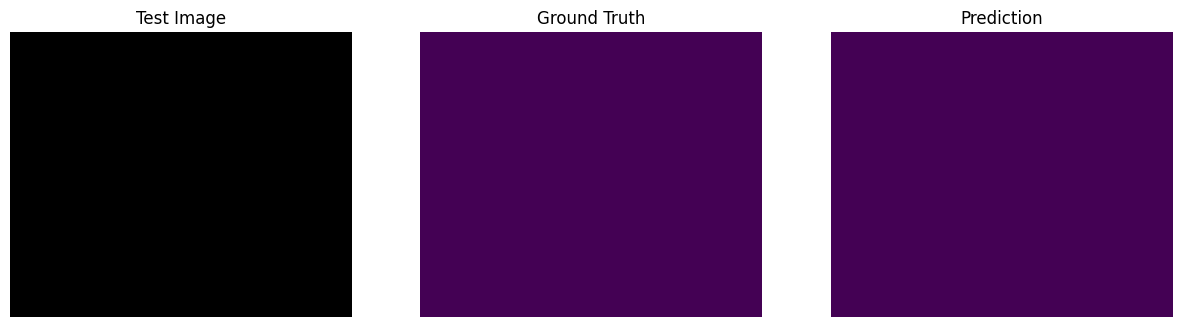

In [14]:
predictions = model.predict(X_val)

print(X_val.shape)
print(Y_val.shape)
print(predictions.shape)

X_val_reconstruct = reconstruct_volume(X_val, (VOLUME_ROWS, VOLUME_COLS, VOLUME_DEPS), PATCH_SIZE, EXTRACTION_STEP)
Y_val_reconstruct = reconstruct_volume(Y_val, (VOLUME_ROWS, VOLUME_COLS, VOLUME_DEPS), PATCH_SIZE, EXTRACTION_STEP)
predictions_reconstruct = reconstruct_volume(predictions, (VOLUME_ROWS, VOLUME_COLS, VOLUME_DEPS), PATCH_SIZE, EXTRACTION_STEP)

print(X_val_reconstruct.shape)
print(Y_val_reconstruct.shape)
print(predictions_reconstruct.shape)

test_index = 0
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Test Image")
plt.axis('off')
plt.imshow(X_val_reconstruct[:, :, 0], cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.axis('off')
plt.imshow(Y_val_reconstruct[:, :, 0], cmap='viridis')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis('off')
plt.imshow(predictions_reconstruct[:, :, 0], cmap='viridis')